# Molecular Modeling


## Goals 

* Learn how to determine the distance between two conformations of the system
* Observe the divergence between trajectories as a function of time
* Quantify the error in a trajectory using time-reversibility

Just to recap, these are our two time evolution equations:

\begin{equation}
\overrightarrow{x}(t+\Delta t) \approx \overrightarrow{x}(t) + \overrightarrow{v}(t) \Delta t,
\end{equation}

\begin{equation}
\overrightarrow{v}(t+\Delta t) \approx \overrightarrow{v}(t) + \Delta t \left(- \frac{1}{m}\nabla U(\overrightarrow{x}) - \gamma \overrightarrow{v} + \sqrt{\frac{2 \gamma k_B T}{m\Delta t} } \overrightarrow{R}(t) \right).
\end{equation}

Our intermolecular potential, the Lennard-Jones potential, looks like this:

\begin{equation}
V_{LJ}(r) = A\left(\frac{r_0}{r}\right)^{12} - B\left(\frac{r_0}{r}\right)^6.
\end{equation}

Let us rewrite the equations in a more compact form. First, let us separate the acceleration:

\begin{equation}
\overrightarrow{a}(t) = - \frac{1}{m}\nabla U(\overrightarrow{x}) - \gamma \overrightarrow{v} + \sqrt{\frac{2 \gamma k_B T}{m\Delta t} } \overrightarrow{R}(t),
\end{equation}
which is essentially the total force divided by the particle mass.

So far we have used a finite-difference scheme, or _integrator_, called the Euler integrator:
\begin{equation}
\overrightarrow{x}(t+\Delta t) \approx \overrightarrow{x}(t) + \overrightarrow{v}(t) \Delta t,
\end{equation}

\begin{equation}
\overrightarrow{v}(t+\Delta t) \approx \overrightarrow{v}(t) + \overrightarrow{a}(t)\Delta t.
\end{equation}

Previously we calcaluted the force inside the function that updates the velocity `updatevel()`. Today we would like to explore the properties of the Euler integrator and then build a more sophisticated scheme, known as the Velocity Verlet integrator.


In [13]:
# import the packages we need in one place
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import cmath as math

We will rearrange the program flow in such a way so that we could experiment with integrators. For this purpose we need to store the forces so that they can be reused on the next time step.
We replace the functions we used before `updatepos()` and `updatevel()` with `updatepos_Euler()` and `updatevel_Euler()`. Study the code below and compare with the code from the Day 21 in-class assignment. To calculate all forces at the same time we introduce a new function `getforces()`.

In [7]:
# collect all the auxiliary functions we need in one block

# update particle positions (all at once)
def updatepos_Euler(whole_xold,whole_vold):
    # returns the new positions, using the old positions and the old velocities
    whole_xnew = whole_xold + whole_vold*dt
    return whole_xnew

# update particle velocities (all at once)
def updatevel_Euler(whole_vold,forces):
    # returns the new velocities, given the old acceleration
    # which is the sum of the external forces, a drag term, and a random force
    vnew = whole_vold + dt*forces
    return vnew

# evaluate all forces as array
def getforces(whole_x,whole_v,dmat):
    all_forces = np.zeros((npart,2))
    for i in range(npart):
        all_forces[i] = -dvdx(i,whole_x,dmat)/m - gamma*whole_v[i] + pref*rfunc()
    return all_forces

# total force on the i-th particle
def dvdx(i,whole_x,dmat):
    # uses the whole position matrix and returns the force vector on particle i
    f0 = np.array([0,0],dtype='double')
    for j in range(npart):
        if j != i:
            if dmat[i][j] < 2*rcutsq:
                d14 = dmat[i][j]**7
                d8  = dmat[i][j]**4
                tmp = -12.0*A*r012/d14 + 6.0*B*r06/d8
                f0[0] += tmp*peri_min(whole_x[i][0],whole_x[j][0])
                f0[1] += tmp*peri_min(whole_x[i][1],whole_x[j][1])
    return f0

# random force drawn from Gaussian distribution
def rfunc():
    # return a vector with components chosen from a Gaussian distribution
    r = np.random.normal(size=2)
    return r

# calculate minimal distance between particles taking into
# account periodic boundary conditions
# (i.e. particles may be closer through the boundary)
def peri_min(x1,x2):
    d1 = x1-x2
    d2 = x1-x2-L
    d3 = x1-x2+L
    if abs(d1) < abs(d2):
        if abs(d1) < abs(d3):
            return d1
        else:
            return d3
    elif abs(d2) < abs(d3):
        return d2
    else:
        return d3

# calculate all interparticle distance as a matrix
def getdistancematrix(x):
    # returns a matrix of particle-particle distances
    dmat = np.zeros((npart,npart))
    for i in range(npart-1):
        for j in range(i+1,npart):
            d = (peri_min(x[i][0],x[j][0]))**2 + (peri_min(x[i][1],x[j][1]))**2
            dmat[i][j]=d
            dmat[j][i]=d
    return dmat

# apply periodic boundary conditions
def pbc_check (xold):
    # check the first component:  xold[0]
    if xold[0] < 0:
        xold[0] += L
    if xold[0] > L:
        xold[0] -= L

    # check the second component:  xold[1]
    if xold[1] < 0:
        xold[1] += L
    if xold[1] > L:
        xold[1] -= L
    return xold

# set initial particle positions
# (check for possible overlaps and retry)
def setup_positions():
    x0 = np.zeros((npart,2))
    for i in range(npart):
        allgood = False
        while (not allgood):
            x0[i] = np.random.random(size=2)

            # check for clashes
            allgood = True
            if i > 0:
                for j in range(i):
                    d = peri_min(x0[i][0],x0[j][0])**2 + peri_min(x0[i][1],x0[j][1])**2
                    if d < rcutsq:
                        allgood = False
    return x0

# NOTE: In this assignment we will set the friction coefficient $\gamma=0$

In this case the friction and random forces are zero and we are left with the deterministic part, resulting from the Lennard-Jones potential.

First, we will repeat the simulation we have done previously, but with a different program flow. Study the code below and compare it to the code that we used in Day 21 in-class activity. Note the main steps: 1) evaluate the distance matrix, 2) evaluate all forces, 3) update the particle positions, 4) update the particle velocities, 5) enforce periodic boundary conditions.

In [8]:
# define our constants
m = 0.5      # the mass of our particles
kT = 1.0     # thermal energy
gamma = 0.0  # friction coefficient
dt = 0.00002 # time step
N = 10000    # number of time steps
npart = 30   # number of particles
r0 = 0.10
L = 1.0
r06 = r0**6
r012 = r0**12
rcutsq = 2*r0**2
A = 1.0
B = 1.0

pref = (2*gamma*kT/m/dt)**(0.5)   # prefactor for random force
                                  # (only compute once and store)


# ----------------------------------
#    simulation starts here
# ----------------------------------


save_int = 100  # how often to save the position

# set random seed for reproducibility
np.random.seed(1)

# this will record our positions as a function of time
traj = np.zeros((int(N/save_int),npart,2))

x0 = setup_positions()   # initial position
v0 = np.random.normal(loc=0,scale=(kT/m)**0.5,size=(npart,2))  # initial velocity

x = x0.copy()
v = v0.copy()


for step in range(N):
    
    dmat = getdistancematrix(x)  # compute the distance matrix only once per time step

    forces = getforces(x,v,dmat) # evaluate all forces

    # update positions
    xn = updatepos_Euler(x,v)

    # update velocities
    vn = updatevel_Euler(v,forces)

    # loop over particles
    for i in range(npart):
        # copy new values into the arrays,
        # apply periodic boundary conditions
        x[i],v[i] = pbc_check(xn[i]),vn[i]
        
    if step % save_int == 0:
        frame = int(step/save_int)
        traj[frame] = x

    if (step+1)*10 % N == 0:
        pct = int((step+1)*10/N)*10
        print ("%d percent completed" % pct)


10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed


As before, we can plot the trajectories.

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


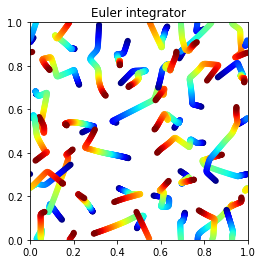

In [9]:
# show all particle trajectories
traj_Euler = traj.copy()
# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

plt.title("Euler integrator")
color=np.array(range(0,int(N/save_int)),dtype='float')
for i in range(npart):
    plt.scatter(traj[:,i,0],traj[:,i,1],c=color,edgecolors='none',cmap='jet')
plt.show()

**Problem 1:** Study the `getdistancematrix()` function above to understand how the distances are calculated (with periodic boundary conditions) and write a function `dist12(x1,x2)` that returns the distance between two particles, with positions `x1` and `x2`. **Note:** The `dist12(x1,x2)` should return distance, not distance squared as the `getdistancematrix()` function.

In [10]:
# x1 and x2 are vectors that hold the positions of a particle
def dist12(x1,x2):
    # your code here
    d = math.sqrt((peri_min(x1[0],x2[0]))**2 + (peri_min(x1[1],x2[1]))**2)
    return d  

**Problem 2:** Write a function `framedist(traj,frame1,frame2)` that gets the distance between two frames (each with `npart` particles).  The frame distance should be the sum of `npart` particle-particle distances. By particle-particle distance we mean the distance between particle `i` in frame `frame1` and particle `i` (i.e. itself) in `frame2`.  Using the `framedist()` function, and the data already stored in the `traj` array, get the distance from frame 0 to all the other frames, and plot this as a function of frame index (time).

In [11]:
# frame1 and frame2 are integers that specify two frame indices
def framedist(traj,frame1,frame2):
    # your code here
    d=0
    for i in range (npart):
        d += dist12(traj[frame1][i],traj[frame2][i])
    return d
    # return the distance between frames

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


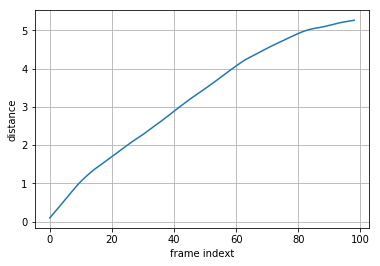

In [19]:
# calculate the distance from frame 0 to all other frames
alldists = []
for f in range(1,int(N/save_int)):
    alldists.append(framedist(traj,0,f))

# plot as function of frame index
plt.plot(alldists)
plt.xlabel('frame indext')
plt.ylabel('distance')
plt.grid()
plt.show()

Now we can test the quality of Euler integrator by running the following test. We integrate the equations of motion for $N$ steps, as we have done above. Then we reverse the sign of the time step $\Delta t\to -\Delta t$. In the absence of drag and stochastic terms the dynamics should be reversible. Thus, continuing and running $N$ more steps with negative time step should bring us back to the initial particle configuration. This way we can test numerical properties of the integrator.

For this purpose we enclose now the main simulation loop inside a function `simulate_forward_and_backward()`.

In [20]:
def simulate_forward_and_backward():
    global dt
    global x, v

    # this will record our positions as a function of time
    traj = np.zeros((int(2*N/save_int),npart,2))
    
    for step in range(N):
    
        dmat = getdistancematrix(x)  # compute the distance matrix only once per time step

        forces = getforces(x,v,dmat) # evaluate all forces

        # update positions
        xn = updatepos_Euler(x,v)

        # update velocities
        vn = updatevel_Euler(v,forces)

        # loop over particles
        for i in range(npart):
            # copy new values into the arrays,
            # apply periodic boundary conditions
            x[i],v[i] = pbc_check(xn[i]),vn[i]
        
        if step % save_int == 0:
            frame = int(step/save_int)
            traj[frame] = x

        if (step+1)*10 % N == 0:
            pct = int((step+1)*10/N)*10
            print ("%d percent completed, forward" % pct)

    # flip the time step -- go back in time
    dt = -dt

    for step in range(N,2*N):
    
        dmat = getdistancematrix(x)  # compute the distance matrix only once per time step

        forces = getforces(x,v,dmat) # evaluate all forces

        # update positions
        xn = updatepos_Euler(x,v)

        # update velocities
        vn = updatevel_Euler(v,forces)

        # loop over particles
        for i in range(npart):
            # copy new values into the arrays,
            # apply periodic boundary conditions
            x[i],v[i] = pbc_check(xn[i]),vn[i]
        
        if step % save_int == 0:
            frame = int(step/save_int)
            traj[frame] = x
        
        if (step+1-N)*10 % N == 0:
            pct = int((step+1-N)*10/N)*10
            print ("%d percent completed, backward" % pct)

    return traj

We are now ready to run forward and backward trajectory. We will do this for three different time steps: $\Delta t=0.00001$, $0.00002$ and $0.00004$. We need to cover the same amount of time, thus, we will have to set different number of time steps for each case: $N=20,000$, $10,000$ and $5,000$. We create a random initial configuration and store it in the arrays `x0,v0`. Then we set the global variables `dt`,`N` and `save_int` and call the function defined above. The results are stored in the arrays `traj1`, `traj2` and `traj3`. The distances between frames for each case are then stored in the lists `alldists1`, `alldists2` and `alldists3`.

In [21]:
# define our constants
m = 0.5      # the mass of our particles
kT = 1.0     # thermal energy
gamma = 0.0  # friction coefficient
npart = 30   # number of particles
r0 = 0.10
L = 1.0
r06 = r0**6
r012 = r0**12
rcutsq = 2*r0**2
A = 1.0
B = 1.0

pref = (2*gamma*kT/m/dt)**(0.5)   # prefactor for random force
                                  # (only compute once and store)


# ----------------------------------
#    simulation starts here
# ----------------------------------


# set random seed for reproducibility
np.random.seed(1)
x0 = setup_positions()   # initial position
v0 = np.random.normal(loc=0,scale=(kT/m)**0.5,size=(npart,2))  # initial velocity


# case 1: time step 0.00001
x = x0.copy()
v = v0.copy()
dt = 0.00001 # time step
N = 20000    # number of time steps
save_int = 200  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj1 = simulate_forward_and_backward()
# calculate the distance from frame 0 to all other frames
alldists1 = []
for f in range(1,int(2*N/save_int)):
    alldists1.append(framedist(traj1,0,f))

# case 2: time step 0.00002
x = x0.copy()
v = v0.copy()
dt = 0.00002 # time step
N = 10000    # number of time steps
save_int = 100  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj2 = simulate_forward_and_backward()
# calculate the distance from frame 0 to all other frames
alldists2 = []
for f in range(1,int(2*N/save_int)):
    alldists2.append(framedist(traj2,0,f))

# case 3: time step 0.00004
x = x0.copy()
v = v0.copy()
dt = 0.00004 # time step
N = 5000    # number of time steps
save_int = 50  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj3 = simulate_forward_and_backward()
# calculate the distance from frame 0 to all other frames
alldists3 = []
for f in range(1,int(2*N/save_int)):
    alldists3.append(framedist(traj3,0,f))


*** Simulation: dt = 1e-05 , N = 20000
10 percent completed, forward
20 percent completed, forward
30 percent completed, forward
40 percent completed, forward
50 percent completed, forward
60 percent completed, forward
70 percent completed, forward
80 percent completed, forward
90 percent completed, forward
100 percent completed, forward
10 percent completed, backward
20 percent completed, backward
30 percent completed, backward
40 percent completed, backward
50 percent completed, backward
60 percent completed, backward
70 percent completed, backward
80 percent completed, backward
90 percent completed, backward
100 percent completed, backward
*** Simulation: dt = 2e-05 , N = 10000
10 percent completed, forward
20 percent completed, forward
30 percent completed, forward
40 percent completed, forward
50 percent completed, forward
60 percent completed, forward
70 percent completed, forward
80 percent completed, forward
90 percent completed, forward
100 percent completed, forward
10 percen

**Problem 3:** Plot the frame distances for the full forward+backward trajectories for the three time steps.

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


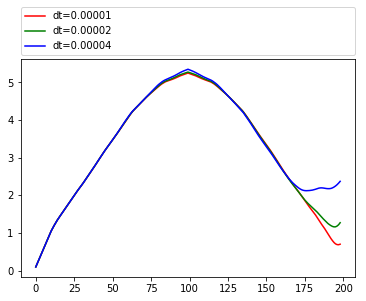

In [22]:
# plot the frame distance for three time steps
plt.plot(alldists1,"r-",label="dt=0.00001")
plt.plot(alldists2,"g-",label="dt=0.00002")
plt.plot(alldists3,"b-",label="dt=0.00004")
plt.legend( bbox_to_anchor = (0., 1.02, 1., 0.102),
            loc = 3,
            ncol=1,
            mode="expand",
            borderaxespad=0. )
plt.show()


# Velocity Verlet integrator

We can now rearrange the finite-difference scheme. First, let us recall that the Euler integrator can be derived from Taylor expanding the position $x(t+\Delta)$ and velocity $v(t+\Delta t)$:

\begin{eqnarray}
\overrightarrow{x}(t+\Delta t)&=&\overrightarrow{x}(t)+\overrightarrow{x}'(t)\Delta  t
+\frac{1}{2}\overrightarrow{x}''(t)\Delta t^2 + \dots\equiv
\overrightarrow{x}(t)+\overrightarrow{v}(t)\Delta  t
+\frac{1}{2}\overrightarrow{a}(t)\Delta t^2 + \dots\\
\overrightarrow{v}(t+\Delta t)&=&\overrightarrow{v}(t)+\overrightarrow{v}'(t)\Delta  t
+\frac{1}{2}\overrightarrow{v}''(t)\Delta t^2 + \dots\equiv
\overrightarrow{v}(t)+\overrightarrow{a}(t)\Delta  t
+\frac{1}{2}\overrightarrow{a}'(t)\Delta t^2 + \dots
\end{eqnarray}

If we retain only the first-order term, we get the Euler integration scheme. The global error would then scale as $O(\Delta t)$. Let us see what happens if we retain the second order term.
The equation for $\overrightarrow{x}(t+\Delta t)$ involves $\overrightarrow{a}(t)$, which is essentially the force evaluated at time step $t$, so to propagate the positions $\overrightarrow{x}$ from $t$ to $t+\Delta t$ we have everything we need: $\overrightarrow{v}(t)$ and $\overrightarrow{a}(t)$. The equation for $\overrightarrow{v}(t+\Delta t)$ however, involves a higher derivative, $\overrightarrow{a}'(t)$ that we do not have. However, we can use forward difference to approximate this derivative as
\begin{equation}
\overrightarrow{a}'(t)\approx \frac{a(t+\Delta t)-a(t)}{\Delta t}.
\end{equation}

When we substitute the approximate expression for the derivative we get:
\begin{eqnarray}
\overrightarrow{x}(t+\Delta t)&=&
\overrightarrow{x}(t)+\overrightarrow{v}(t)\Delta  t
+\frac{1}{2}\overrightarrow{a}(t)\Delta t^2 + \dots\\
\overrightarrow{v}(t+\Delta t)&=&
\overrightarrow{v}(t)
+\frac{1}{2}\left(\overrightarrow{a}(t)+\overrightarrow{a}(t+\Delta t)\right)\Delta t + \dots
\end{eqnarray}

This scheme is the most efficient when the forces depend only on positions and not velocities, which is the case when $\gamma=0$. The update scheme is then the following:
* update the positions: $\overrightarrow{x}(t)\to\overrightarrow{x}(t+\Delta t)$,
* calculate the forces with updated(!) positions: $\overrightarrow{x}(t+\Delta t)\to\overrightarrow{a}(t+\Delta t)$,
* update the velocities using the new forces $\overrightarrow{a}(t+\Delta t)$ and the forces from the previous time step $\overrightarrow{a}(t)$.

In practice, we store the new forces in the `forces` array, and the forces from the previous step in the `forces_old` array. At the end of the update we copy `forces` to `forces_old` to reuse them in the next time step. Study the code blocks below to understand the difference between the code for the Euler and Velocity Verlet method.

Some other useful resources are:

* [Velocity Verlet](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet)

**Note that the Velocity Verlet is a more stable method and we can use time step $\Delta t$ 10 times larger than in the Euler case.**

In [23]:
# update particle positions (all at once)
def updatepos_VelVerlet(whole_xold,whole_vold,forces_old):
    # returns the new positions, using the old positions and the old velocities
    whole_xnew = whole_xold + dt * ( whole_vold + 0.5*forces_old*dt )
    return whole_xnew


# update particle velocities (all at once)
def updatevel_VelVerlet(whole_vold,forces_old,forces):
    # returns the new velocities, given the old acceleration
    # which is the sum of the external forces, a drag term, and a random force
    vnew = whole_vold + 0.5*dt*(forces_old+forces)
    return vnew



In [24]:
# define our constants
m = 0.5      # the mass of our particles
kT = 1.0     # thermal energy
gamma = 0.0  # friction coefficient
dt = 0.0002  # time step
N = 1000     # number of time steps
npart = 30   # number of particles
r0 = 0.10
L = 1.0
r06 = r0**6
r012 = r0**12
rcutsq = 2*r0**2
A = 1.0
B = 1.0

pref = (2*gamma*kT/m/dt)**(0.5)   # prefactor for random force
                                  # (only compute once and store)


# ----------------------------------
#    simulation starts here
# ----------------------------------


save_int = 10  # how often to save the position

# set random seed for reproducibility
np.random.seed(1)

# this will record our positions as a function of time
traj = np.zeros((int(N/save_int),npart,2))

x0 = setup_positions()   # initial position
v0 = np.random.normal(loc=0,scale=(kT/m)**0.5,size=(npart,2))  # initial velocity

x = x0.copy()
v = v0.copy()

# get distance matrix
dmat = getdistancematrix(x)
# precalculate forces
forces_old = getforces(x,v,dmat)

for step in range(N):

    # update positions
    xn = updatepos_VelVerlet(x,v,forces_old)

    # compute the distance matrix for new positions(!)
    dmat = getdistancematrix(xn)

    # evaluate forces with new positions(!)
    forces = getforces(xn,v,dmat)

    # update velocities
    vn = updatevel_VelVerlet(v,forces_old,forces)

    # loop over particles
    for i in range(npart):
        # copy new values into the arrays,
        # apply periodic boundary conditions
        x[i],v[i] = pbc_check(xn[i]),vn[i]

    # copy the force array to force_old
    # to reuse on the next step
    forces_old = forces.copy()

    if step % save_int == 0:
        frame = int(step/save_int)
        traj[frame] = x

    if (step+1)*10 % N == 0:
        pct = int((step+1)*10/N)*10
        print ("%d percent completed" % pct)


10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed


Compare the plot with particle trajectories calculated with the Velocity Verlet method ($\Delta t = 0.0002$) with the Euler case ($\Delta t=0.00002$). The color scheme in the plot below is reversed.

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


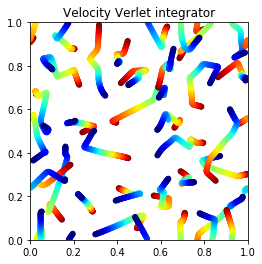

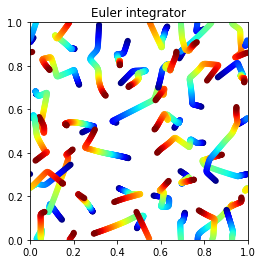

In [25]:
# show all particle trajectories

# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

plt.title("Velocity Verlet integrator")
color=np.array(range(int(N/save_int),0,-1),dtype='float')
for i in range(npart):
    plt.scatter(traj[:,i,0],traj[:,i,1],c=color,edgecolors='none',cmap='jet')
plt.show()

# set the size of the plot
plt.xlim(0,L)
plt.ylim(0,L)
# set the plot aspect ratio to square
plt.axes().set_aspect('equal')

plt.title("Euler integrator")
color=np.array(range(0,int(N/save_int)),dtype='float')
for i in range(npart):
    plt.scatter(traj_Euler[:,i,0],traj_Euler[:,i,1],c=color,edgecolors='none',cmap='jet')
plt.show()



**Problem 4:** Using the function `framedist(traj,frame1,frame2)` calculate the frame distances as in Problem 2.

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


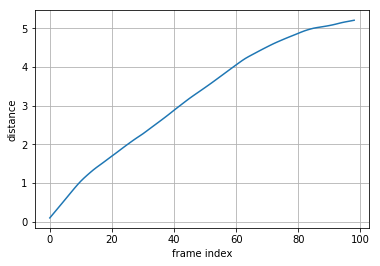

In [28]:
alldists = []
for f in range(1,int(N/save_int)):
    alldists.append(framedist(traj,0,f))

plt.plot(alldists)
plt.xlabel('frame index')
plt.ylabel('distance')
plt.grid()
plt.show()

We can now test forward and backward integration for the Velocity Verlet integrator. For this purpose we define a function `simulate_forward_and_backward_VV()`.

In [29]:
def simulate_forward_and_backward_VV():
    global dt
    global x, v

    # this will record our positions as a function of time
    traj = np.zeros((int(2*N/save_int),npart,2))
    
    # compute the distance matrix
    dmat = getdistancematrix(x)
    # precalculate forces
    forces_old = getforces(x,v,dmat) # evaluate all forces

    for step in range(N):

        # update positions
        xn = updatepos_VelVerlet(x,v,forces_old)

        # compute the distance matrix for new positions(!)
        dmat = getdistancematrix(xn)

        # evaluate forces with new positions(!)
        forces = getforces(xn,v,dmat)

        # update velocities
        vn = updatevel_VelVerlet(v,forces_old,forces)

        # loop over particles
        for i in range(npart):
            # copy new values into the arrays,
            # apply periodic boundary conditions
            x[i],v[i] = pbc_check(xn[i]),vn[i]

        # copy the force array to force_old
        # to reuse on the next step
        forces_old = forces.copy()
        
        if step % save_int == 0:
            frame = int(step/save_int)
            traj[frame] = x

        if (step+1)*10 % N == 0:
            pct = int((step+1)*10/N)*10
            print ("%d percent completed, forward" % pct)

    # flip the time step -- go back in time
    dt = -dt

    # compute the distance matrix
    dmat = getdistancematrix(x)
    # precalculate forces
    forces_old = getforces(x,v,dmat) # evaluate all forces

    for step in range(N,2*N):

        # update positions
        xn = updatepos_VelVerlet(x,v,forces_old)

        # compute the distance matrix for new positions(!)
        dmat = getdistancematrix(xn)

        # evaluate forces with new positions(!)
        forces = getforces(xn,v,dmat)

        # update velocities
        vn = updatevel_VelVerlet(v,forces_old,forces)

        # loop over particles
        for i in range(npart):
            # copy new values into the arrays,
            # apply periodic boundary conditions
            x[i],v[i] = pbc_check(xn[i]),vn[i]

        # copy the force array to force_old
        # to reuse on the next step
        forces_old = forces.copy()
        
        if step % save_int == 0:
            frame = int(step/save_int)
            traj[frame] = x
        
        if (step+1-N)*10 % N == 0:
            pct = int((step+1-N)*10/N)*10
            print ("%d percent completed, backward" % pct)

    return traj

Run the simulation below. Note that the time steps are 10 times larger than for the Euler integrator.

In [30]:
# define our constants
m = 0.5      # the mass of our particles
kT = 1.0     # thermal energy
gamma = 0.0  # friction coefficient
npart = 30   # number of particles
r0 = 0.10
L = 1.0
r06 = r0**6
r012 = r0**12
rcutsq = 2*r0**2
A = 1.0
B = 1.0

pref = (2*gamma*kT/m/dt)**(0.5)   # prefactor for random force
                                  # (only compute once and store)


# ----------------------------------
#    simulation starts here
# ----------------------------------


# set random seed for reproducibility
np.random.seed(1)
x0 = setup_positions()   # initial position
v0 = np.random.normal(loc=0,scale=(kT/m)**0.5,size=(npart,2))  # initial velocity

# case 1: time step 0.0001
x = x0.copy()
v = v0.copy()
dt = 0.0001 # time step
N = 2000    # number of time steps
save_int = 20  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj1 = simulate_forward_and_backward_VV()
# calculate the distance from frame 0 to all other frames
alldists1 = []
for f in range(1,int(2*N/save_int)):
    alldists1.append(framedist(traj1,0,f))

# case 2: time step 0.0002
x = x0.copy()
v = v0.copy()
dt = 0.0002 # time step
N = 1000    # number of time steps
save_int = 10  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj2 = simulate_forward_and_backward_VV()
alldists2 = []
for f in range(1,int(2*N/save_int)):
    alldists2.append(framedist(traj2,0,f))

# case 3: time step 0.0004
x = x0.copy()
v = v0.copy()
dt = 0.0004 # time step
N = 500    # number of time steps
save_int = 5  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj3 = simulate_forward_and_backward_VV()
# calculate the distance from frame 0 to all other frames
alldists3 = []
for f in range(1,int(2*N/save_int)):
    alldists3.append(framedist(traj3,0,f))


*** Simulation: dt = 0.0001 , N = 2000
10 percent completed, forward
20 percent completed, forward
30 percent completed, forward
40 percent completed, forward
50 percent completed, forward
60 percent completed, forward
70 percent completed, forward
80 percent completed, forward
90 percent completed, forward
100 percent completed, forward
10 percent completed, backward
20 percent completed, backward
30 percent completed, backward
40 percent completed, backward
50 percent completed, backward
60 percent completed, backward
70 percent completed, backward
80 percent completed, backward
90 percent completed, backward
100 percent completed, backward
*** Simulation: dt = 0.0002 , N = 1000
10 percent completed, forward
20 percent completed, forward
30 percent completed, forward
40 percent completed, forward
50 percent completed, forward
60 percent completed, forward
70 percent completed, forward
80 percent completed, forward
90 percent completed, forward
100 percent completed, forward
10 percen

**Problem 5:** Plot the frame distances for the full forward+backward trajectories for the three time steps, as in Problem 3.

/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


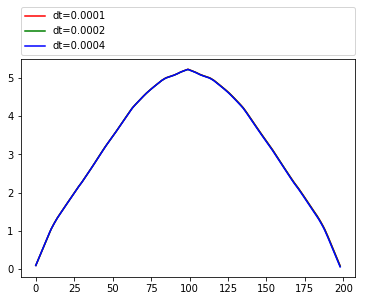

In [31]:
# plot the frame distance for three time steps
plt.plot(alldists1,"r-",label="dt=0.0001")
plt.plot(alldists2,"g-",label="dt=0.0002")
plt.plot(alldists3,"b-",label="dt=0.0004")
plt.legend( bbox_to_anchor = (0., 1.02, 1., 0.102),
            loc = 3,
            ncol=1,
            mode="expand",
            borderaxespad=0. )
plt.show()


In [32]:
# case 4: time step 0.00005
x = x0.copy()
v = v0.copy()
dt = 0.00005 # time step
N = 4000    # number of time steps
save_int = 40  # how often to save the position
print("*** Simulation: dt =",dt,", N =",N)
traj4 = simulate_forward_and_backward_VV()
# calculate the distance from frame 0 to all other frames
alldists4 = []
for f in range(1,int(2*N/save_int)):
    alldists4.append(framedist(traj4,0,f))

*** Simulation: dt = 5e-05 , N = 4000
10 percent completed, forward
20 percent completed, forward
30 percent completed, forward
40 percent completed, forward
50 percent completed, forward
60 percent completed, forward
70 percent completed, forward
80 percent completed, forward
90 percent completed, forward
100 percent completed, forward
10 percent completed, backward
20 percent completed, backward
30 percent completed, backward
40 percent completed, backward
50 percent completed, backward
60 percent completed, backward
70 percent completed, backward
80 percent completed, backward
90 percent completed, backward
100 percent completed, backward


/Users/fangchunliang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


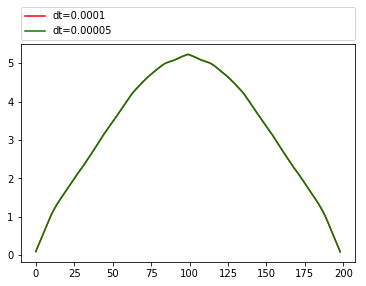

In [35]:
# plot the frame distance for three time steps
plt.plot(alldists1,"r-",label="dt=0.0001")
plt.plot(alldists4,"g-",label="dt=0.00005")
plt.legend( bbox_to_anchor = (0., 1.02, 1., 0.102),
            loc = 3,
            ncol=1,
            mode="expand",
            borderaxespad=0. )
plt.show()

**Problem 6:** Discuss your observations and compare the Euler and Velocity Verlet integration schemes.

For our case (gamma=0), Velocity Verlet integration scheme is better than Euler one. Compared with graph in Problem 3, the one in Problem 6 is much better mirror-like. It means that the trajectory from Velocity Verlet integration scheme is (more) reversible. Decreasing the time step to half (0.00005), they still converge at the same position.